[*********************100%***********************]  1 of 1 completed


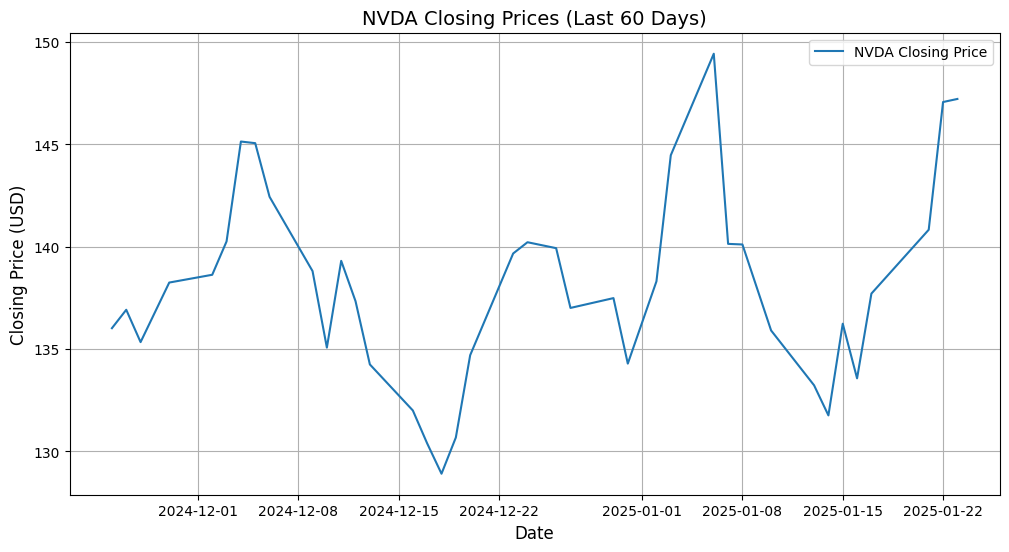

In [38]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define the ticker and date range
ticker = "NVDA"
end_date = datetime.now()
start_date = end_date - timedelta(days=60)

# Fetch the data
nvda_data = yf.download(ticker, start=start_date, end=end_date)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(nvda_data.index, nvda_data['Close'], label='NVDA Closing Price')
plt.title(f'NVDA Closing Prices (Last 60 Days)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [47]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import GPy
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation, PillowWriter

# Define the ticker and date range
ticker = "NVDA"
end_date = datetime.now()
start_date = end_date - timedelta(days=60)

# Fetch the data
nvda_data = yf.download(ticker, start=start_date, end=end_date)
nvda_data = nvda_data[['Close']].dropna()

# Prepare time and price data
time = np.arange(len(nvda_data)).reshape(-1, 1)  # Time indices
prices = nvda_data['Close'].values.reshape(-1, 1)

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))
line_mean, = ax.plot([], [], 'b-', label="GP Mean Prediction")
line_true, = ax.plot([], [], 'k-', label="True Prices")
fill_uncertainty = ax.fill_between([], [], [], color='blue', alpha=0.2, label="Uncertainty Bounds")
ax.set_title('Gaussian Process Predictions Over Time', fontsize=14)
ax.set_xlabel('Time Index', fontsize=12)
ax.set_ylabel('Closing Price (USD)', fontsize=12)
ax.legend()
ax.grid()

# Gaussian Process kernel and model setup
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=10.0)

# Function to update the frame for each iteration
def update_frame(i):
    if i < 2:
        return line_mean, line_true, fill_uncertainty  # Skip early frames with insufficient data
    
    # Data up to current frame (use all t-1 points for training)
    train_time = time[:i]
    train_prices = prices[:i]

    # Fit Gaussian Process
    model = GPy.models.GPRegression(train_time, train_prices, kernel)
    model.optimize(messages=False)

    # Make predictions for the full range of data
    pred_time = np.arange(len(nvda_data)).reshape(-1, 1)  # Full range of time for predictions
    mean, variance = model.predict(pred_time)
    std_dev = np.sqrt(variance)

    # Update lines
    line_true.set_data(time[:i], prices[:i])  # True data
    line_mean.set_data(pred_time, mean)  # Predicted mean

    # Update uncertainty fill
    ax.collections.clear()  # Clear previous fill
    ax.fill_between(pred_time.flatten(),
                    (mean - 2 * std_dev).flatten(),
                    (mean + 2 * std_dev).flatten(),
                    color='blue', alpha=0.2, label="Uncertainty Bounds")

    ax.relim()
    ax.autoscale_view()
    return line_mean, line_true, fill_uncertainty

# Create animation
anim = FuncAnimation(fig, update_frame, frames=len(nvda_data), interval=100, blit=False)

# Save as GIF
anim.save('gp_nvda_forecast.gif', writer=PillowWriter(fps=10))
plt.close()

print("GIF saved as 'gp_nvda_forecast.gif'.")


[*********************100%***********************]  1 of 1 completed


 /home/fanpu/ml/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/fanpu/ml/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GIF saved as 'gp_nvda_forecast.gif'.


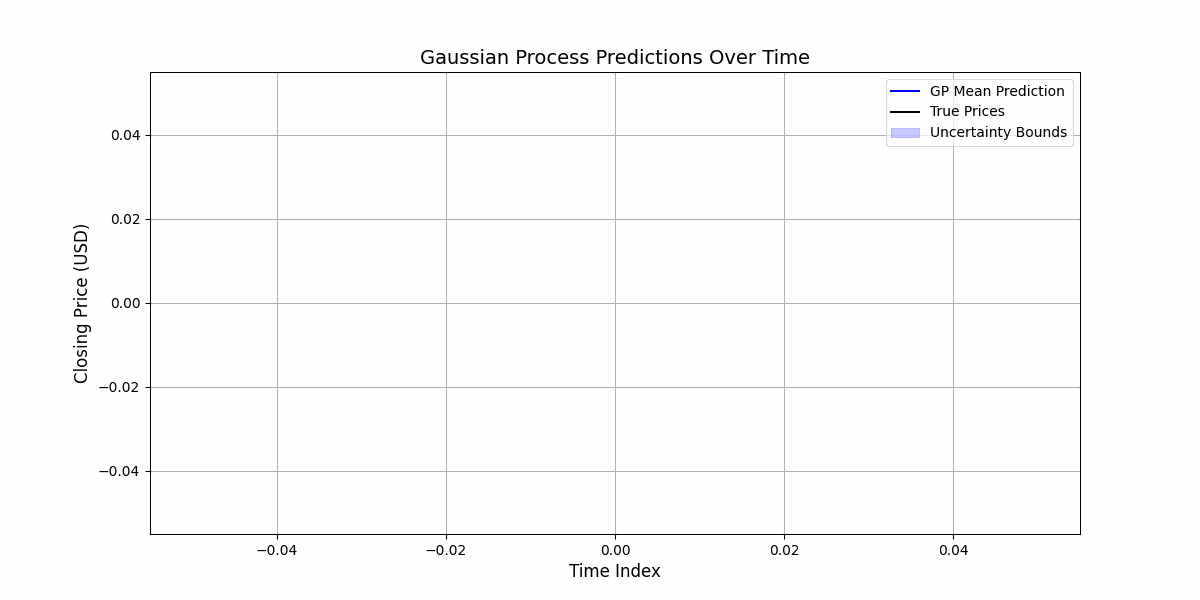

In [48]:
from IPython.display import Image, display

# Display the GIF
display(Image(filename='gp_nvda_forecast.gif'))


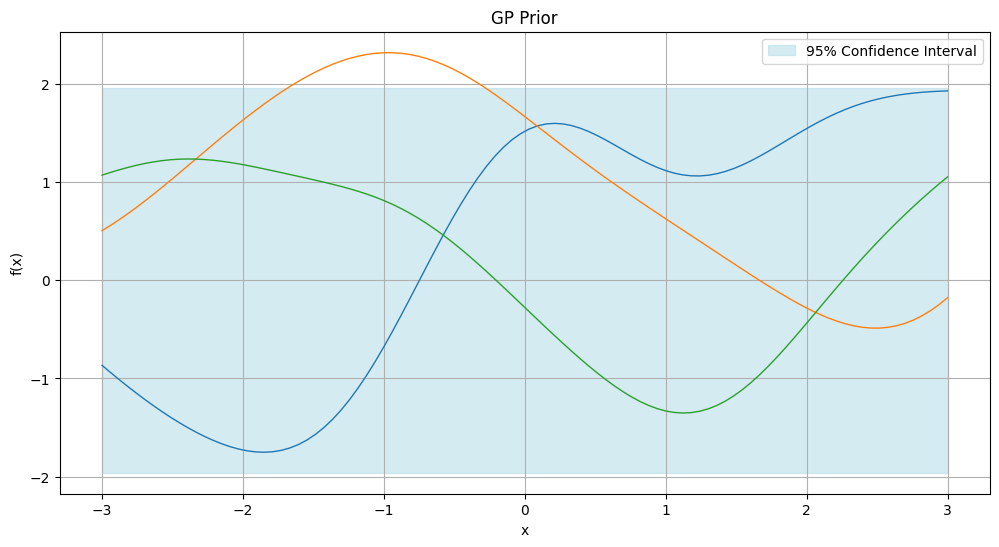

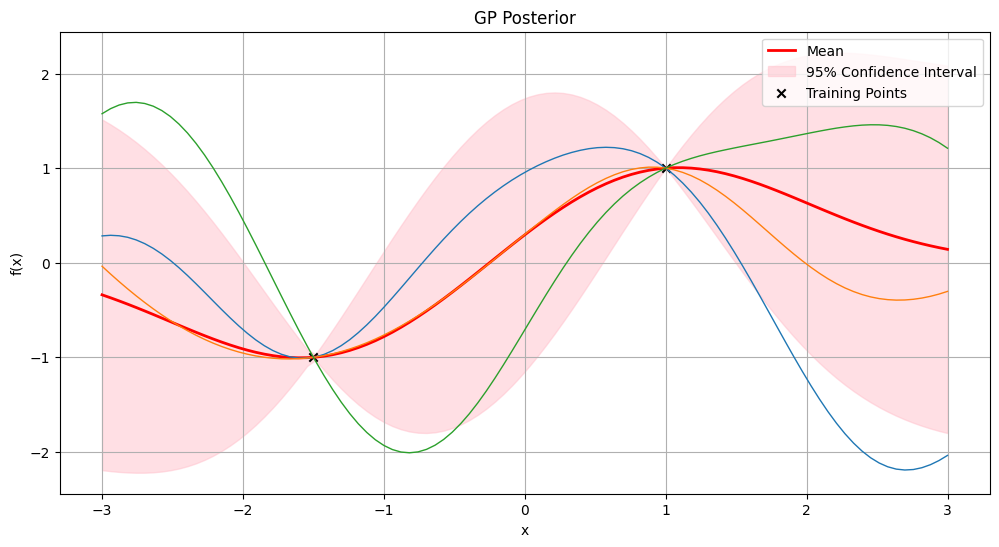

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Define the squared exponential (RBF) kernel
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """Compute the RBF kernel between two sets of inputs."""
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

# Define the GP prior and posterior computation
def gp_prior_and_posterior(X_train, y_train, X_test, length_scale=1.0, variance=1.0, noise_variance=1e-10):
    # Compute the covariance matrices
    K = rbf_kernel(X_train, X_train, length_scale, variance) + noise_variance * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_test, length_scale, variance)
    K_ss = rbf_kernel(X_test, X_test, length_scale, variance) + 1e-8 * np.eye(len(X_test))

    # Compute the mean and covariance of the posterior
    K_inv = np.linalg.inv(K)
    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, cov_s

# Generate data
X_train = np.array([[-1.5], [1.0]])  # Training inputs
y_train = np.array([-1.0, 1.0])      # Training targets
X_test = np.linspace(-3, 3, 100).reshape(-1, 1)  # Test inputs

# Compute the GP prior and posterior
length_scale = 1.0
variance = 1.0
mu_s, cov_s = gp_prior_and_posterior(X_train, y_train, X_test, length_scale, variance)

# Compute the prior mean and covariance
K_prior = rbf_kernel(X_test, X_test, length_scale, variance)
prior_mean = np.zeros(len(X_test))
prior_std = np.sqrt(np.diag(K_prior))

# Generate prior samples
prior_samples = np.random.multivariate_normal(prior_mean, K_prior, 3)

# Plot the GP prior with 95% confidence interval
plt.figure(figsize=(12, 6))
plt.plot(X_test, prior_samples.T, lw=1)
plt.fill_between(X_test.ravel(),
                 prior_mean - 1.96 * prior_std,
                 prior_mean + 1.96 * prior_std,
                 color="lightblue", alpha=0.5, label="95% Confidence Interval")
plt.title("GP Prior")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend()
plt.show()


# Sample from the posterior
posterior_samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

# Plot the GP posterior
plt.figure(figsize=(12, 6))
plt.plot(X_test, mu_s, 'r', lw=2, label="Mean")
plt.fill_between(X_test.ravel(),
                 mu_s.ravel() - 1.96 * np.sqrt(np.diag(cov_s)),
                 mu_s.ravel() + 1.96 * np.sqrt(np.diag(cov_s)),
                 color="pink", alpha=0.5, label="95% Confidence Interval")
plt.scatter(X_train, y_train, c="black", marker="x", label="Training Points")
plt.plot(X_test, posterior_samples.T, lw=1)
plt.title("GP Posterior")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()
plt.show()

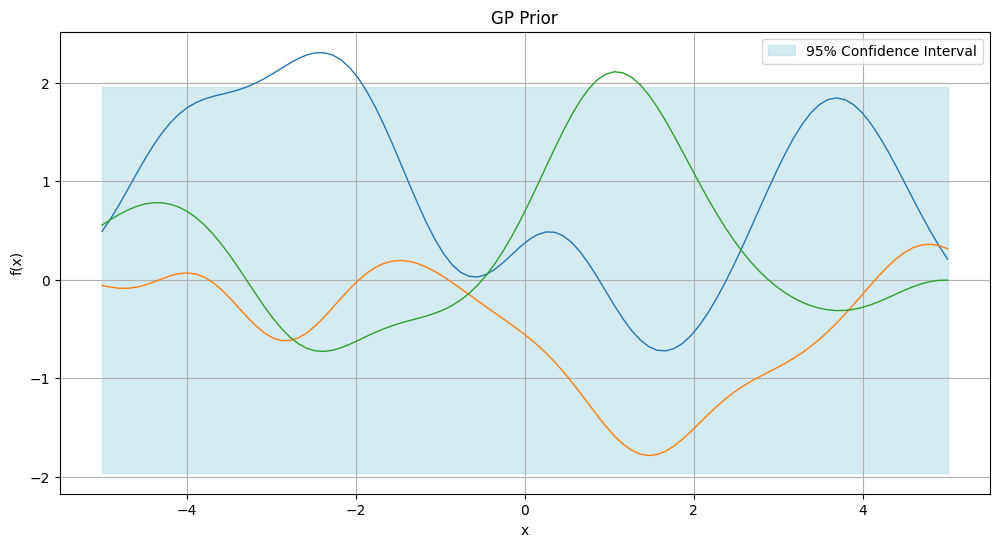

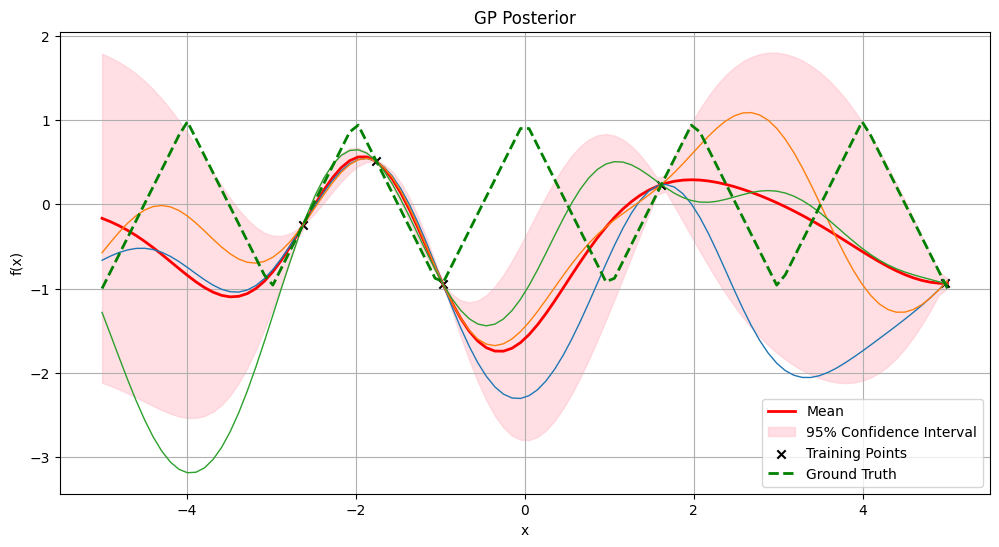

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define the squared exponential (RBF) kernel
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """Compute the RBF kernel between two sets of inputs."""
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

# Define the GP prior and posterior computation
def gp_prior_and_posterior(X_train, y_train, X_test, length_scale=1.0, variance=1.0, noise_variance=1e-10):
    # Compute the covariance matrices
    K = rbf_kernel(X_train, X_train, length_scale, variance) + noise_variance * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_test, length_scale, variance)
    K_ss = rbf_kernel(X_test, X_test, length_scale, variance) + 1e-8 * np.eye(len(X_test))

    # Compute the mean and covariance of the posterior
    K_inv = np.linalg.inv(K)
    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, cov_s

# Triangle function
def triangle_function(x):
    """Triangle wave function."""
    return 2 * np.abs((x % 2) - 1) - 1

# Number of training points
num_train_points = 5

# Range for the plot
plot_range = (-5, 5)

# Generate training data
X_train = np.random.uniform(plot_range[0], plot_range[1], num_train_points).reshape(-1, 1)  # Random training inputs
y_train = triangle_function(X_train).ravel()                      # Training targets

# Generate test inputs
X_test = np.linspace(plot_range[0], plot_range[1], 100).reshape(-1, 1)

# Compute the GP prior and posterior
length_scale = 1.0
variance = 1.0
mu_s, cov_s = gp_prior_and_posterior(X_train, y_train, X_test, length_scale, variance)

# Compute the prior mean and covariance
K_prior = rbf_kernel(X_test, X_test, length_scale, variance)
prior_mean = np.zeros(len(X_test))
prior_std = np.sqrt(np.diag(K_prior))

# Generate prior samples
prior_samples = np.random.multivariate_normal(prior_mean, K_prior, 3)

# Plot the GP prior with 95% confidence interval
plt.figure(figsize=(12, 6))
plt.plot(X_test, prior_samples.T, lw=1)
plt.fill_between(X_test.ravel(),
                 prior_mean - 1.96 * prior_std,
                 prior_mean + 1.96 * prior_std,
                 color="lightblue", alpha=0.5, label="95% Confidence Interval")
plt.title("GP Prior")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend()
plt.show()

# Sample from the posterior
posterior_samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

# Plot the GP posterior
plt.figure(figsize=(12, 6))
plt.plot(X_test, mu_s, 'r', lw=2, label="Mean")
plt.fill_between(X_test.ravel(),
                 mu_s.ravel() - 1.96 * np.sqrt(np.diag(cov_s)),
                 mu_s.ravel() + 1.96 * np.sqrt(np.diag(cov_s)),
                 color="pink", alpha=0.5, label="95% Confidence Interval")
plt.scatter(X_train, y_train, c="black", marker="x", label="Training Points")
plt.plot(X_test, posterior_samples.T, lw=1)
plt.plot(X_test, triangle_function(X_test), 'g--', lw=2, label="Ground Truth")
plt.title("GP Posterior")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()
plt.show()


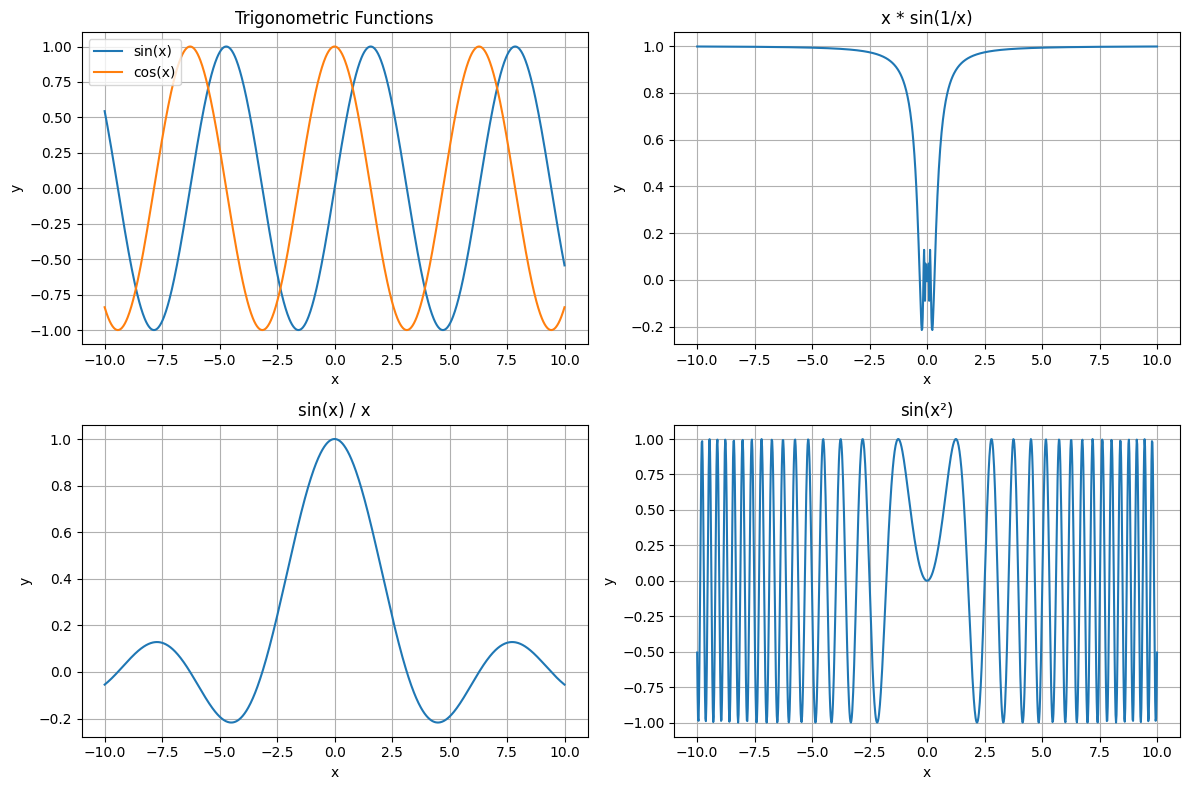

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
plt.figure(figsize=(12, 8))

# Generate x values
x = np.linspace(-10, 10, 1000)

# Plot 1: Standard Trigonometric Functions
plt.subplot(2, 2, 1)
plt.plot(x, np.sin(x), label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.title('Trigonometric Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# Plot 2: x * sin(1/x)
plt.subplot(2, 2, 2)
# Avoid division by zero
x_special = x[x != 0]
plt.plot(x_special, x_special * np.sin(1/x_special))
plt.title('x * sin(1/x)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Plot 3: Damped Oscillation
plt.subplot(2, 2, 3)
plt.plot(x, np.sin(x) / x)
plt.title('sin(x) / x')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Plot 4: Complex Oscillation
plt.subplot(2, 2, 4)
plt.plot(x, np.sin(x**2))
plt.title('sin(x²)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.tight_layout()
plt.show()

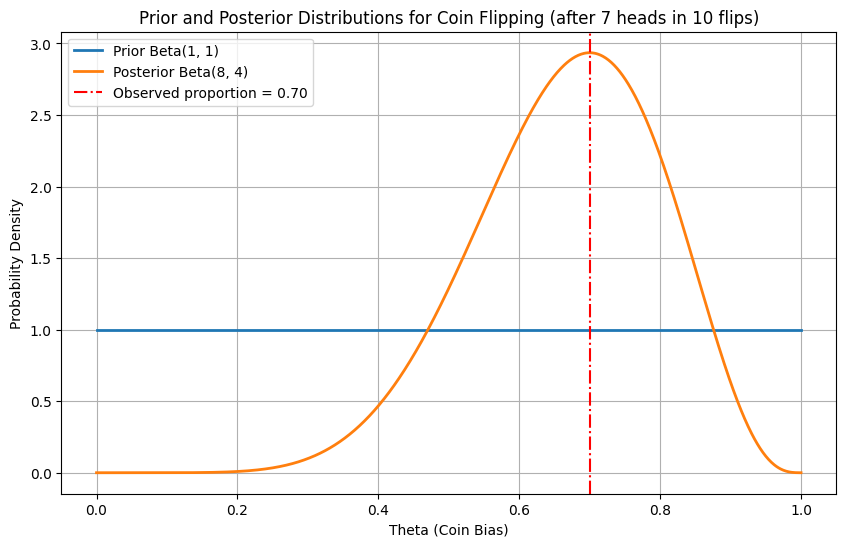

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Observations (7 heads out of 10 flips)
x = 7  # Number of heads
n = 10  # Total number of flips

# Prior parameters for Beta distribution (Uniform prior Beta(1, 1))
alpha_prior = 1
beta_prior = 1

# Update posterior parameters
alpha_posterior = alpha_prior + x
beta_posterior = beta_prior + n - x

# Plotting the prior and posterior distributions
theta = np.linspace(0, 1, 1000)  # Range of theta values

# Compute prior and posterior distributions
prior_pdf = beta.pdf(theta, alpha_prior, beta_prior)
posterior_pdf = beta.pdf(theta, alpha_posterior, beta_posterior)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(theta, prior_pdf, label=f"Prior Beta({alpha_prior}, {beta_prior})", linewidth=2)
plt.plot(theta, posterior_pdf, label=f"Posterior Beta({alpha_posterior}, {beta_posterior})", linewidth=2)

# Indicate the observed proportion of heads on the graph
observed_theta = x / n
plt.axvline(observed_theta, color="red", linestyle="-.", label=f"Observed proportion = {observed_theta:.2f}")

plt.title("Prior and Posterior Distributions for Coin Flipping (after 7 heads in 10 flips)")
plt.xlabel("Theta (Coin Bias)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()


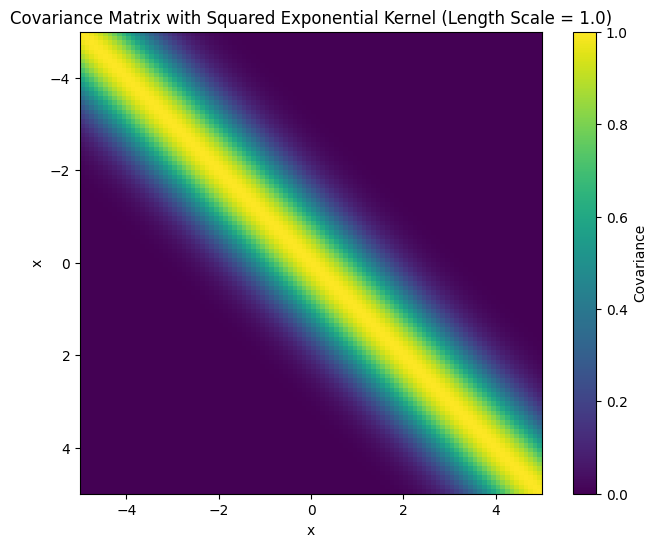

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0):
    return np.exp(-0.5 * ((x1 - x2) / length_scale) ** 2)

# Generate evenly spaced points in 1D
num_points = 100  # Number of points
x = np.linspace(-5, 5, num_points)

# Compute the covariance matrix using the RBF kernel
length_scale = 1.0
covariance_matrix = np.array([[rbf_kernel(xi, xj, length_scale) for xj in x] for xi in x])

# Plot the covariance matrix
plt.figure(figsize=(8, 6))
plt.imshow(covariance_matrix, cmap='viridis', extent=[x[0], x[-1], x[-1], x[0]])
plt.colorbar(label='Covariance')
plt.title(f'Covariance Matrix with Squared Exponential Kernel (Length Scale = {length_scale})')
plt.xlabel('x')
plt.ylabel('x')
plt.show()
